In [1]:
import warnings; warnings.simplefilter('ignore')

In [2]:
import pandas as pd 
import numpy as np 
import re,string
from bs4 import BeautifulSoup

In [3]:
from nltk import sent_tokenize, word_tokenize
from nltk import bigrams, trigrams
from nltk import WordNetLemmatizer

from nltk.util import ngrams, pad_sequence
from collections import Counter, defaultdict
from nltk.corpus import stopwords

In [4]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras import losses
from tensorflow.keras import backend
from tensorflow.keras import callbacks

In [5]:
ftrain=open("train.txt", "r",encoding="utf-8")
text_raw = ftrain.read()

In [6]:
def prepare_text(text_raw):
    text = text_raw
    # replace \n characters with space
    text=re.sub('\n',' ',text)
    # remove html tags
    soup = BeautifulSoup(text, "html.parser")
    text = soup.get_text()  
    # convert to lower case
    text = text.lower()

    text_sents = sent_tokenize(text)

    all_tokens = []
    text_sents_cleaned = []
    tokenized_word_sents = []
    for s in text_sents:
        s_cleaned = re.sub("[^a-zA-Z]", " ", s)
        s_words = word_tokenize(s_cleaned)
        for t in s_words:
            all_tokens.append(t)
        if(len(s_words) > 0):
            text_sents_cleaned.append(s_cleaned)
            tokenized_word_sents.append(s_words)

    all_tokens.append('none')
    all_tokens.append('None')
    all_tokens.append('<s>')
    all_tokens.append('</s>')

    print("len of all sentences: ",len(tokenized_word_sents))
    print("len of all tokens: ",len(all_tokens))
    return all_tokens, text_sents_cleaned, tokenized_word_sents

In [7]:
all_tokens, text_sents_cleaned, tokenized_word_sents = prepare_text(text_raw)

len of all sentences:  42801
len of all tokens:  839510


In [8]:
def build_glove_word2vec():
    from gensim.test.utils import datapath, get_tmpfile
    from gensim.models import KeyedVectors
    from gensim.scripts.glove2word2vec import glove2word2vec

    glove_file = datapath('F:\\Projects\\CA-3\\glove.6B.50d.txt')
    tmp_file = get_tmpfile('F:\\Projects\\CA-3\\word2vec.txt')

    word2vec_shape = glove2word2vec(glove_file, tmp_file)

    print("word2vec_shape --> num_lines , dims : " , word2vec_shape)
    word2vec_model = KeyedVectors.load_word2vec_format(tmp_file)
    return word2vec_model

In [9]:
word2vec_model = build_glove_word2vec()

word2vec_shape --> num_lines , dims :  (400000, 50)


In [12]:
def build_encoder(all_tokens):
    from sklearn.preprocessing import LabelEncoder
    from sklearn.preprocessing import OneHotEncoder

    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(all_tokens)
    #vocab_size = len(label_encoder.classes_)
    #print("vocab_size: ", vocab_size)

    # binary encode
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)

    onehot_encoder = OneHotEncoder(sparse=False, dtype='uint8')
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    
    return label_encoder, onehot_encoder


In [13]:
label_encoder, onehot_encoder = build_encoder(all_tokens)

vocab_size = len(label_encoder.classes_)
print(vocab_size)

57500


In [18]:
def generate_file_ngram_X_Y(onehot_encoder, label_encoder, tokenized_word_sents, file_name):
    file_data = open(file_name, "ab")    
    count = 0
    countError = 0
    for sentence in tokenized_word_sents:    
        #s_padded = pad_sequence(sentence,pad_left=True,left_pad_symbol="<s>",pad_right=True,right_pad_symbol="</s>",n=2)
        for w1, w2, w3, w4 in ngrams(sentence, pad_right=False, pad_left=False, n=4):
            count += 1
            #print(w1, w2, w3, w4)
            try:
                v1 = list(word2vec_model.get_vector(str(w1).lower()))
                v2 = list(word2vec_model.get_vector(str(w2).lower()))
                v3 = list(word2vec_model.get_vector(str(w3).lower()))
                y_word = str(w4).lower()
                index_y_word = [label_encoder.transform([y_word])]
                np.savetxt(file_data, [v1+v2+v3+index_y_word], fmt="%2.6f",delimiter=",")
            except:
                #print('Error during get vector for:{} {} {} {}'.format(w1, w2, w3, w4))
                countError+=1
                pass
    print("count of 4-grams={}".format(count))        
    print("count on unknown 4-grams={}".format(countError)) 
    file_data.close()
    return

In [19]:
#generate_file_ngram_X_Y(onehot_encoder, label_encoder, tokenized_word_sents, "train_4gram_nopad_vectors.csv")

In [20]:
ftest=open("test.txt", "r",encoding="utf-8")
test_text_raw = ftest.read()
test_all_tokens, test_text_sents_cleaned, test_tokenized_word_sents = prepare_text(test_text_raw)

len of all sentences:  992
len of all tokens:  20031


In [21]:
generate_file_ngram_X_Y(onehot_encoder, label_encoder, test_tokenized_word_sents, "test_4gram_nopad_vectors.csv")

count of 4-grams=17058
count on unknown 4-grams=1307


In [22]:
train_data = np.loadtxt('train_4gram_nopad_vectors.csv', delimiter=',')

In [23]:
num_train_4grams = len(train_data)
print(num_train_4grams)

687418


In [24]:
test_data = np.loadtxt('test_4gram_nopad_vectors.csv', delimiter=',')

In [25]:
num_test_4grams = len(test_data)
print(num_test_4grams)

15751


In [30]:
#print(history.history['val_perplexity'])
def perplexity(y_true, y_pred):
    cross_entropy = losses.categorical_crossentropy(y_true, y_pred)
    perplexity = backend.pow(2.0, cross_entropy)
    return perplexity

In [31]:
from tensorflow.keras.optimizers import SGD

def build_model(input_dim, vocab_size, hidden_units, learning_rate):
    model = Sequential()
    model.add(Dense(hidden_units, input_dim=input_dim, activation='sigmoid'))
    model.add(Dense(vocab_size, activation='softmax'))
    sgd = SGD(lr=learning_rate, momentum=0., decay=0., nesterov=False)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=[perplexity])
    return model

In [32]:
class ReportCallback(callbacks.Callback):

    def on_epoch_end(self, epoch, logs={}):
        print("Epoch {}: perplexity={}, loss={}, val_perplexity={}, val_loss={},".format(
                epoch, logs["perplexity"], logs["loss"], logs["val_perplexity"], logs["val_loss"]))

In [37]:
import random 
def generator_batch (input_size, vocab_size, ngrams_data, batch_size, num_data):
    batch_features = np.zeros((batch_size, input_size))
    batch_labels = np.zeros((batch_size,vocab_size))        
    while True:
        index = random.randrange(num_data-batch_size-1)
        #selected_data = np.loadtxt(csv_filename, delimiter=',', skiprows=index, max_rows=batch_size)
        selected_data = ngrams_data[index:index+batch_size]
        for i in range(len(selected_data)):
            batch_features[i] = selected_data[i][:input_size]
            y1= np.array([int(selected_data[i][input_size])])
            d = onehot_encoder.transform(y1.reshape(-1, 1))
            batch_labels[i] = list(d[0])                       
        
        yield batch_features, batch_labels   

In [47]:
print("num_train_4grams:", num_train_4grams)
print("num_test_4grams:", num_test_4grams)
input_size = len(train_data[0])-1
print("input_size:", input_size)
print("vocab_size:", vocab_size)
batch_size = 32
steps_per_epoch = int(num_train_4grams/batch_size)
validation_steps = int(num_test_4grams/batch_size)
print("steps_per_epoch:", steps_per_epoch)
print("validation_steps:", validation_steps)

num_train_4grams: 687418
num_test_4grams: 15751
input_size: 150
vocab_size: 57500
steps_per_epoch: 21481
validation_steps: 492


In [48]:
model = build_model(input_size, vocab_size,hidden_units=35, learning_rate=0.02)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 35)                5285      
_________________________________________________________________
dense_5 (Dense)              (None, 57500)             2070000   
Total params: 2,075,285
Trainable params: 2,075,285
Non-trainable params: 0
_________________________________________________________________


In [49]:
def train_model(model, model_filepath, pretrained_weights, epoch_num):
    if (pretrained_weights == True):
        model.load_weights(model_filepath)
    #--------------------------------------
    checkpointer = ModelCheckpoint(model_filepath, monitor='val_perplexity', verbose=1, save_best_only=True, mode='min')

    metrics = model.fit_generator(generator_batch(input_size, vocab_size, train_data, batch_size, num_train_4grams), 
                              steps_per_epoch=1000, 
                              validation_data=generator_batch(input_size, vocab_size, test_data, batch_size, num_test_4grams), 
                              validation_steps=30, 
                              epochs=epoch_num, verbose=0, callbacks=[ReportCallback(),checkpointer], workers=10,shuffle=True)    
    return metrics

In [50]:
model_filepath = 'model_lm_4w_35n_lr_02_glove.hdf5'
metrics = train_model(model, model_filepath, pretrained_weights=True, epoch_num=10)

Epoch 0: perplexity=1122.5933036499023, loss=7.85652641916275, val_perplexity=1126.7573364257812, val_loss=7.778114525477092,

Epoch 00001: val_perplexity improved from inf to 1126.75734, saving model to model_lm_4w_35n_lr_02_glove.hdf5
Epoch 1: perplexity=1129.507167175293, loss=7.8137776894569395, val_perplexity=1190.4450764973958, val_loss=7.839623483022054,

Epoch 00002: val_perplexity did not improve from 1126.75734
Epoch 2: perplexity=1135.1454075317383, loss=7.827349756240845, val_perplexity=1216.451064046224, val_loss=7.891106414794922,

Epoch 00003: val_perplexity did not improve from 1126.75734
Epoch 3: perplexity=1126.3824002075196, loss=7.8209453926086425, val_perplexity=1061.5955891927083, val_loss=7.6842365741729735,

Epoch 00004: val_perplexity improved from 1126.75734 to 1061.59559, saving model to model_lm_4w_35n_lr_02_glove.hdf5
Epoch 4: perplexity=1126.8381640319824, loss=7.807613355159759, val_perplexity=1134.1749247233072, val_loss=7.828449789683024,

Epoch 00005: 

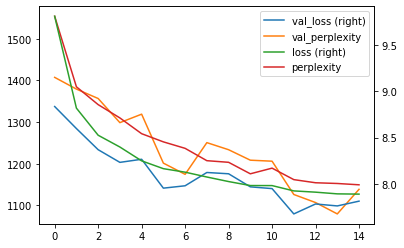

In [44]:
#print(metrics.history['val_perplexity'])
result = pd.DataFrame.from_dict(metrics.history)
result.plot.line(secondary_y=["loss", "val_loss"])

In [51]:
perp_trfile = open('perp_train_lm_4w_35n_lr_02_glove.csv', "ab")    
np.savetxt(perp_trfile, metrics.history.get('perplexity'), fmt="%2.6f",delimiter=",")
perp_trfile.close()

perp_tsfile = open('perp_test_lm_4w_35n_lr_02_glove.csv', "ab")    
np.savetxt(perp_tsfile, metrics.history.get('val_perplexity'), fmt="%2.6f",delimiter=",")
perp_tsfile.close()

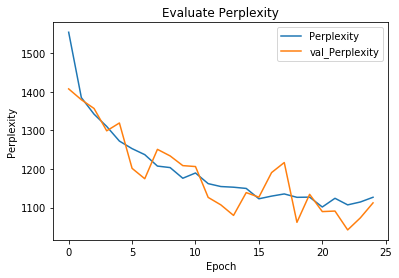

In [5]:
import matplotlib.pyplot as plt
import numpy as np

train_perp = np.loadtxt('perp_train_lm_4w_35n_lr_02_glove.csv', delimiter=',')
test_perp = np.loadtxt('perp_test_lm_4w_35n_lr_02_glove.csv', delimiter=',')

x1 = np.array(range(len(train_perp)))
x2 = np.array(range(len(test_perp)))

# plot the data
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(x1, train_perp, color='tab:blue', label='Perplexity')
ax.plot(x2, test_perp, color='tab:orange', label='val_Perplexity')

ax.set_title("Evaluate Perplexity")
ax.set_xlabel('Epoch')
ax.set_ylabel('Perplexity')
plt.legend(loc="upper right")
plt.show()
